<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S12_ImageCaption_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Mon May 17 17:56:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Reference : https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning
This notebook is based on above reference. Code below is heavily commented at each line. This code is built with a focus on deploying to cloud thereby addressing space limitations of models.Encoder is using pre-trained RESNET-18.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install torch==1.5.0+cu92 torchvision==0.6.0+cu92 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 31kB/s 
     |████████████████████████████████| 6.5MB 405kB/s 
     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 1.2MB 14.8MB/s 
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [4]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 95kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [5]:
import torch
import torchvision
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import json
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.0+cu92


# Inference

In [6]:
with open("/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json", "r") as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}

In [7]:
encoder = torch.jit.load("/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/Test_flickr8k_caption.encoder.scripted.pt")
decoder = torch.jit.load("/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/Test_flickr8k_caption.decoder.scripted.pt")

In [24]:
#! wget -O playing.jpg https://cff2.earth.com/uploads/2018/07/25115124/Kids-now-spend-twice-as-much-time-playing-indoors-than-outdoors.jpg
img_dog = '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/jumping_dog.jpg'
img_football = '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/maradona.jpg'
img_dance = '/content/gdrive/MyDrive/EVA4P2_S12_ImageCaptioning/Dancing.jpg'

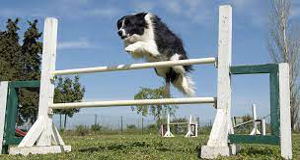

In [20]:
from PIL import Image
img = Image.open(img_dog)
img = img.resize((300, 160))
img

In [10]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = Image.open(image_path)

    trans = T.Compose(
        [
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    image = trans(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(
        k, num_pixels, encoder_dim
    )  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.tensor([[word_map["<start>"]]] * k, dtype=torch.long) # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    #seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    #complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(
            encoder_out, h
        )  # (s, encoder_dim), (s, num_pixels)

        '''
        alpha = alpha.view(
            -1, enc_image_size, enc_image_size
        )  # (s, enc_image_size, enc_image_size)
        '''

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(
            torch.cat([embeddings, awe], dim=1), (h, c)
        )  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        # import pdb; pdb.set_trace()
        seqs = torch.cat(
            [seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1
        )  # (s, step+1)
        #seqs_alpha = torch.cat(
        #    [seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
        #)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [
            ind
            for ind, next_word in enumerate(next_word_inds)
            if next_word != word_map["<end>"]
        ]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            #complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        #seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    #alphas = complete_seqs_alpha[i]

    #return seq, alphas
    return seq

In [15]:
with torch.no_grad():
    seq = caption_image_beam_search(encoder, decoder, img_dog, word_map, beam_size=3)
seq

[2631, 1, 2, 44, 7, 3, 4, 368, 158, 1, 7, 214, 2632]

In [16]:
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
words

'a black and white dog is jumping over a white fence'

In [17]:
with torch.no_grad():
    seq = caption_image_beam_search(encoder, decoder, img_cat, word_map, beam_size=3)
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
words

'a white dog jumps to catch a tennis ball'

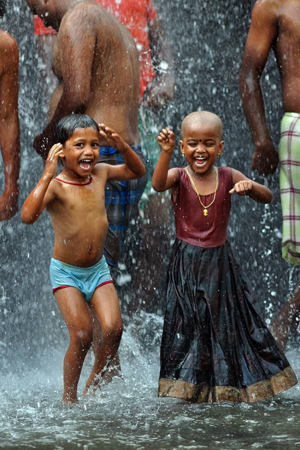

In [23]:
from PIL import Image
img = Image.open(img_dance)
img = img.resize((300, 450))
img

In [18]:
with torch.no_grad():
    seq = caption_image_beam_search(encoder, decoder, img_dance, word_map, beam_size=3)
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
words

'a group of children are playing in the water'

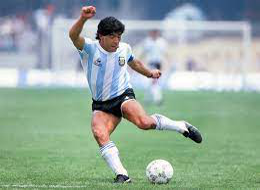

In [25]:
from PIL import Image
img = Image.open(img_football)
img = img.resize((260, 190))
img

In [26]:
with torch.no_grad():
    seq = caption_image_beam_search(encoder, decoder, img_football, word_map, beam_size=3)
words = " ".join([rev_word_map[ind] for ind in seq if ind not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
words

'a man in a white shirt is playing soccer'